In [1]:
import pandas as pd
import math
import numpy as np
from datetime import datetime,date
import pytz
import matplotlib.pyplot as plt
#from IPython.core.ultratb import VerboseTB
#from IPython.display import display, HTML
#display(HTML("<style>.container { width:90% !important; }</style>"))
#VerboseTB._tb_highlight = "bg:#039dfc"
import scipy.optimize as spo
import time
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import plot_model
import requests
import json
#from hyperopt import fmin, tpe, hp, Trials

In [2]:
#print(tf.__version__)
#print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
#tf.test.is_built_with_cuda()


In [3]:
class TechnicalIndicators():
    def __init__(self, data_frame):
        self.df = data_frame.copy()

    # calculation of the return of column after an interval of n days
    def momentum(self, column, n, offset=0):
        if f'{column}_momentum_{n}*' not in self.df.columns:
            close_prices = self.df.loc[offset:,column]
            momentum = close_prices / close_prices.shift(n) - 1
            momentum[0:n]=1
            self.df[f'{column}_momentum_{n}'] = momentum
            
        return self.df[f'{column}_momentum_{n}']
    
    # moving average of column i of returns through n days
    def simple_movement_average(self, column, n, offset=0):
        if f'{column}_sma_{n}*' not in self.df.columns:
            window_mean = self.df.loc[offset:,column].rolling(n).mean()
            window_mean[0:n]=  window_mean[n]
            self.df[f'{column}_sma_{n}'] = self.df[column] / window_mean - 1
        return self.df[f'{column}_sma_{n}']
    
    # calculate upper and lower 2*std_deviation lines
    def _get_bollinger_bands(self, rm, rstd):
        upper_band = rm + rstd * 2
        lower_band = rm - rstd * 2
        return upper_band, lower_band
    
    # moving average and +/- 2*std_deviation lines
    def bollinger_bands(self, column, window_size=20, offset=0):
        if f'{column}_upper_band*' not in self.df.columns:
            self.df[f'{column}_mm20'] = self.df.loc[offset:,column].rolling(window_size).mean()
            self.df.loc[0:window_size,f'{column}_mm20'] =  self.df.loc[window_size,f'{column}_mm20']
            rstd = self.df.loc[offset:,column].rolling(window_size).std()
            rstd.iloc[0:window_size] = rstd.iloc[window_size]
            self.df[f'{column}_upper_band'], self.df[f'{column}_lower_band'] = self._get_bollinger_bands(self.df[f'{column}_mm20'], rstd)
        return self.df[[column, f'{column}_mm20', f'{column}_upper_band', f'{column}_lower_band']]
    
    # daily and cumulative returns of column
    def add_daily_return(self,column):
        self.df[f'{column}_daily_return'] = (self.df[column] / self.df[column].shift(1)) - 1
        self.df.loc[0,f'{column}_daily_return'] = 0
        self.df[f'{column}_cumulative_return'] = (self.df[column] / self.df[column].values[0]) - 1
        self.df.loc[0,f'{column}_cumulative_return'] = 0
        
    # log return after n days of column
    def log_returns(self,column,n):
        self.df[f'{column}_log_return_{n}'] = np.log((self.df[column] / self.df[column].shift(n)))
        self.df.loc[0:n,f'{column}_log_return_{n}'] = self.df.loc[n,f'{column}_log_return_{n}']
        return self.df[f'{column}_log_return_{n}']
    
    

In [ ]:
# get stock (ticker) data from yahoo finance from start to end dates
class stock_dataframe():
    def __init__(self,ticker, start=0,end=0):
        self.ticker = ticker
        self.start = start 
        self.end = end

#    def conv_df(resp):
#        j = resp.json()
#        data = [j['chart']['result'][0]['timestamp']] + list(j['chart']['result'][0]['indicators']['quote'][0].values() + list(j['chart']['result'][0]['indicators']['adjclose'][0].values())
#        df = pd.DataFrame(
#        {'timestamp': data[0], 'close': data[1], 'open': data[2], 'high': data[3], 'low': data[4], 'volume': data[5], 'adjclose': data[6]})
#        df['time'] = pd.to_datetime(df['timestamp'], unit='s')
#        df['date'] = df['time'].apply(lambda x: x.strftime('%Y-%m-%d'))
#        return df
        
    def get_yahoo_stock_data(self):
        start_date = date.fromisoformat(self.start)
        end_date = date.fromisoformat(self.end)
        start_stamp = int(datetime(start_date.year, start_date.month, start_date.day, tzinfo=pytz.UTC).timestamp())
        end_stamp = int(datetime(end_date.year, end_date.month, end_date.day, tzinfo=pytz.UTC).timestamp())
        print(start_date, end_date)
        #self.start_stamp = datetime.timestamp(self.start_date)
        #self.end_stamp = datetime.timestamp(self.end_date)
        print(start_stamp,end_stamp)
        url = "https://query2.finance.yahoo.com/v8/finance/chart/%s?period1=%i&period2=%i&interval=1d&events=history&includeAdjustedclose=true" % (self.ticker,start_stamp,end_stamp)
        print(url)
        response = requests.get(url,headers = {'User-agent': 'Request %s' % self.ticker})
        data = response.json()
        result = data["chart"]["result"][0]
        stock = pd.DataFrame(result["indicators"]["quote"][0])
        stock['adjclose'] = result["indicators"]["adjclose"][0]["adjclose"]
        stock['date'] = pd.to_datetime(result["timestamp"], unit='s')
        self.stock = stock.dropna()
        #print(json.dumps(data, indent=4))
        #data = json.loads(response.text)
        #self.stock = pd.read_csv(url)
       # self.stock = pd.json_normalize(response.json())
        #print(self.stock)
        self.stock["relhigh"] = self.stock["high"]/self.stock["adjclose"]
        self.stock["rellow"] = self.stock["low"]/self.stock["adjclose"]
        self.stock["relopen"] = self.stock["open"]/self.stock["adjclose"]
        return self.stock
    
    def get_brapi_stock_data(self, RANGE = '3mo', INTERVALO = '1d'):
       
        self.stock = pd.DataFrame()
        API_KEY = 'gjx1h4PNSzSAJFqmzgsteD' 
        for ATIVO in self.ticker:
            #time.sleep(1)  # Aguarda 1 segundo entre as requisições para evitar sobrecarga no servidor
            # URL da API brapi
            URL = f"https://brapi.dev/api/quote/{ATIVO}?range={RANGE}&interval={INTERVALO}&token={API_KEY}"

            
            try:
                response = requests.get(URL)
                response.raise_for_status() # Lança um erro para códigos de status 4xx/5xx
            except:
                self.ticker.remove(ATIVO)
                continue
            print(f"Buscando dados diários para o ativo: {ATIVO}...")

            # Converte a resposta JSON
            data = response.json()
            # --- 2. Extração dos Dados ---
            # O JSON da brapi contém os dados da série histórica dentro de 'results'[0]['historicalData']
            # Verifica se 'historicalData' existe
            historical_data = pd.DataFrame(data['results'][0].get('historicalDataPrice'))
            #print("stock data", historical_data)
            
            historical_data["relhigh"] = historical_data["high"]/historical_data["close"]
            historical_data["rellow"] = historical_data["low"]/historical_data["close"]
            historical_data["relopen"] = historical_data["open"]/historical_data["close"]
            historical_data['date'] = pd.to_datetime(historical_data["date"], unit='s')
            print (historical_data)
            if self.stock.empty:
                self.stock = historical_data.add_prefix(ATIVO+"_")
                self.stock.rename(columns={ATIVO+"_date": "date"}, inplace=True)
            else:
            #    print(self.stock)
                self.stock = pd.merge(self.stock,historical_data.add_prefix(ATIVO+"_"), left_on="date", right_on=ATIVO+"_date")
                #print(self.stock)
                #self.stock.drop(ATIVO+"_date")
        self.stock['date'] = pd.to_datetime(self.stock["date"], unit='s')

        self.stock = self.stock.dropna()
        print("Final stock data", self.ticker)
        
        return self.stock, self.ticker
    
    # Convert Date to Day, Month and Year columns.
    def Date_Convert(self):
        self.stock['date'] = pd.to_datetime(self.stock['date'])
        self.stock['year'] = self.stock['date'].dt.year
        self.stock['month'] = self.stock['date'].dt.month
        self.stock['day'] = self.stock['date'].dt.day
        
    # define Scaler
    def Standard_Scaler(self):
        self.scaler = StandardScaler()
    
    def Min_Max_Scaler(self):
        self.scaler = MinMaxScaler()
        
    # Calculate technical indicators    
    def Get_Technical_Indicators(self,price):
        TI = TechnicalIndicators(self.stock)
        TI.momentum(price,15)
        TI.simple_movement_average(price,15)
        TI.bollinger_bands(price,15)
        TI.add_daily_return(price)
        TI.log_returns(price,1)
        self.stock = TI.df
        return self.stock
        
    # Perform Chosen normalization    
    def Normalize(self):
        # Copy the DataFrame
        stock_normalized = self.stock.copy()

        # Apply StandardScaler to the subset of columns
        stock_normalized = (self.stock - self.stock.mean())/self.stock.std()

        return stock_normalized



In [11]:
# Class for calculating option weights for an optimal portfolio for each day 
class PortfolioOptimization:
    def __init__(self, data_frame, options):
        self.df = data_frame.copy()
        self.options = options.copy()
        self.init_weights()

     # initialize weights        
    def init_weights(self):
        for stock in self.options:
            if f'{stock}_weight' not in self.df.columns:
                self.df[f"{stock}_weight"] = 1 / len(self.options)

    # constraints for optimization. Might not be needed in case W_i/sum(W_i) is used             
    def _constraints(self, weights):
        return np.sum(weights) - 1
    
    # Sharpe ration calculation of the full portfolio. Currently using constant as risk free return
    def sharpe_ratio(self, weights, returns, std, rfree):
        norm_weights = weights / np.sum(weights)
        total_return = np.sum(norm_weights * returns)
        portfolio_stddev = np.sum(norm_weights*norm_weights*std*std)
        return (total_return - rfree) / portfolio_stddev
    
    # Minimize target funcion, maximizing the Sharpe ratio
    def target_function(self, weights, returns, stddev, rfree):
        return -self.sharpe_ratio(weights, returns, stddev, rfree)

    # weight optimization using scikit.optmize.minimize. Might not be the best choice, still can test alternatives. Need to check optimized values 
    def optimize_weights(self, weights, returns, stddev, rfree):
        constraints = {'type': 'eq', 'fun': self._constraints}
        bounds = [(0, 1) for _ in range(len(weights))]

        result = spo.minimize(
            self.target_function,
            weights,
            args=(returns, stddev, rfree),
            constraints=constraints,
            bounds=bounds,
            method='SLSQP'  # Sequential Least Squares Programming optimizer
        )
        
        if not result.success:
            raise ValueError(f"Optimization failed: {result.message}")

        return result.x
    
    # Apply optimization for each row. 
    def get_optimal_weights(self, rfree=0.0001):
        weight_columns = [col for col in self.df.columns if col.endswith('_weight')]
        return_columns = [col.replace('_weight', '_adjustedClose_log_return_1') for col in weight_columns]
        stddev_columns = [self.df[col].std() for col in return_columns]

        def apply_optimization(row):
            weights = row[weight_columns].values
            returns = row[return_columns].values
            optimal_weights = self.optimize_weights(weights, returns, stddev_columns, rfree)
            return pd.Series(optimal_weights, index=weight_columns)

        # df.apply was tricky to use with a function with many parameters, to be applied in many columns. This was the workaround which worked  
        self.df[weight_columns] = self.df.apply(apply_optimization, axis=1)
        return self.df[weight_columns]

In [12]:
class data_prep(): 
    def __init__(
        self, 
        df, 
        features, 
        targets, 
        train_fraction=0.5, 
        validation_fraction=0.25, 
        rwin=7, 
        offset=1, 
    ):
        self.df = df.copy()
        self.features = features.copy()
        self.targets = targets.copy()
        self.train_fraction = train_fraction
        self.validation_fraction = validation_fraction
        self.rwin = rwin
        self.offset = offset

    def calculate_metrics(self):
        Met = Metrics(self.Train_Dat[self.targets],self.Train_Pred[self.targets],self.targets)
        self.train_pull  = M_Train.pull()
        self.train_chisq = M_Train.chisq()
        self.train_mse   = M_Train.get_mse()

        return self
    
    def create_sequences(self):
        self.sequences = []
        self.featureval = self.df[self.features].values
        for start_idx in range(len(self.featureval) - self.rwin + 1):
            end_idx = start_idx + self.rwin
            sequence = self.featureval[start_idx:end_idx]
            self.sequences.append(sequence)
            
        return self.sequences

    def create_targetval(self):
        self.targetval = self.df[self.targets].values
        return self.targetval
    
    def split_data(self):
        train_split = int((len(self.targetval) - self.rwin)*self.train_fraction)
        validation_split = int((len(self.targetval) - self.rwin)*self.validation_fraction)
        train_sequences = self.sequences[:train_split]
        validation_sequences = self.sequences[train_split:train_split + validation_split]
        test_sequences = self.sequences[train_split + validation_split:]
        train_targets = self.targetval[self.rwin+self.offset:self.rwin+self.offset + train_split]
        validation_targets = self.targetval[self.rwin+self.offset + train_split:self.rwin+self.offset + train_split + validation_split]
        test_targets = self.targetval[self.rwin+self.offset + train_split + validation_split:]
        print("len(self.sequences) = ", len(self.sequences))
        print("len(self.targetval) = ", len(self.targetval))
        print("self.rwin = ", self.rwin)
        print("self.train_fraction = ", self.train_fraction)
        print("self.validation_fraction = ", self.validation_fraction)
        print("train_split = ", train_split)
        print("valdation_split = ", validation_split)
        return train_sequences, validation_sequences, test_sequences, train_targets, validation_targets, test_targets
        

In [13]:
# class for calculating evaluation metrics of the model
class Metrics():
    def __init__(self, in_df, pred_df, targets):
        common_indices = in_df.index.intersection(pred_df.index)
        common_indices = common_indices[:-1]
        self.in_df = in_df.loc[common_indices].copy()
        self.pred_df = pred_df.loc[common_indices].copy()
        self.targets = targets.copy()
        self.out = pd.DataFrame()
        self.mse = {}

    # pull = (predicted - data)/std_dev    
    def pull(self):
        for column in self.targets:
            # Ensure both return Series
            in_series = self.in_df[column].squeeze()
            pred_series = self.pred_df[column].squeeze()
            diff = pred_series - in_series
            in_std = self.in_df[column].std()
            pred_std = self.in_df[column].std()
            pull = diff/math.sqrt(pow(in_std,2) + pow(pred_std,2))
            self.out[f'{column}_Pull'] = pull
        return self.out.filter(like='Pull')

    # chisq = (predicted - data)**2/std_dec**2
    def chisq(self):
        for column in self.targets:
            in_series = self.in_df[column].squeeze()
            pred_series = self.pred_df[column].squeeze()
            diff = pred_series - in_series
            in_std = self.in_df[column].std()
            pred_std = self.in_df[column].std()
            chisq = diff*diff/(pow(in_std,2) + pow(pred_std,2))
            self.out[f'{column}_ChiSq'] = chisq
        return self.out.filter(like='ChiSq')
    
    # mse = sum(chisq)/n_rows for every row
    def get_mse(self):
        for column in self.targets:
            if f'{column}_ChiSq' not in self.out.columns:
                self.chisq()
            self.mse[column] = self.out[f'{column}_ChiSq'].sum()/len(self.out[f'{column}_ChiSq'])
            return self.mse

In [14]:
class model_builder():
    def __init__(
        self,
        df,
        features,
        targets,
        offset
    ):
        self.df = df
        self.features = features
        self.targets = targets
        self.offset = offset

    def set_space(self):
        self.space = {
            'nlstmlayers': hp.quniform('nlstmlayers', 1, 3, 1),
            'ndenselayers': hp.quniform('ndenselayers', 1, 3, 1),
            'rwin': hp.quniform('rwin', 5, 90, 5),
            'lstmunits': hp.quniform('lstmunits', len(self.features), len(self.features)*10, len(self.features)),
            'denseunits': hp.quniform('denseunits', len(self.targets), len(self.features), 1),
            'activation': hp.choice('activation', ['relu', 'tanh', 'linear']),
            'optimizer': hp.choice('optimizer', ['adam', 'sgd']),
            'epochs': hp.quniform('epochs',1,101,10),
            'batch': hp.quniform('batch', 1, 5, 1)
        }
        return self.space

    def build_eval(self,params):
        begin = time.time()
        nlstmlayers = int(params['nlstmlayers'])
        ndenselayers = int(params['ndenselayers'])
        lstmunits = int(params['lstmunits'])
        denseunits = int(params['denseunits'])
        activation = params['activation']
        optimizer = params['optimizer']
        epochs = int(params['epochs'])
        batch =int( pow(2,params['batch']))
        rwin =int(params['rwin'])

        dp = data_prep(self.df,self.features, self.targets, rwin = rwin, offset = self.offset)
        self.sequences = dp.create_sequences()
        self.targetvals = dp.create_targetval()

        train_sequences, validation_sequences, test_sequences, train_targets, validation_targets, test_targets = dp.split_data()

        model = Sequential()

        print(params)

        #print('train_sequences.shape=',train_sequences.shape)


        for L in range(nlstmlayers):
            #print('L = ', L, 'nlstmlayers = ', nlstmlayers)
            if L == (nlstmlayers-1) : model.add(LSTM(lstmunits, activation=activation, input_shape=(rwin, len(self.features)), return_sequences=False))
            else: model.add(LSTM(lstmunits, activation=activation, input_shape=(rwin, len(self.features)), return_sequences=True))

        for L in range(ndenselayers):
            model.add(Dense(denseunits, activation = activation))

        model.add(Dense(len(self.targets), activation = activation))
        model.compile(optimizer=optimizer, loss='mse')
        print(model.summary())
        config = model.get_config()
        #print("input",config["layers"][0]["config"]["batch_input_shape"])
        model.fit(train_sequences, train_targets, epochs=epochs, verbose=0,batch_size = batch)
        loss = model.evaluate(validation_sequences, validation_targets, verbose=0)

        end = time.time()
        print('iteration lasted', end-begin)

        return loss


In [19]:

#options = [
#           "ITUB4.SA",
#           "VALE3.SA"
#          ]
options = [
              "ALOS3", "ABEV3", "ASAI3", "AURE3", "AXIA3", "AXIA6", "AZZA3", "B3SA3", "BBSE3", "BBDC3",
    "BBDC4", "BRAP4", "BBAS3", "BRKM5", "BRAV3", "BPAC11", "CXSE3", "CEAB3", "CMIG4", "COGN3",
    "CPLE5", "CSAN3", "CPFE3", "CMIN3", "CURY3", "CVCB3", "CYRE3", "DIRR3", "EMBJ3", "ENGI11",
    "ENEV3", "EGIE3", "EQTL3", "FLRY3", "GGBR4", "GOAU4", "HAPV3", "HYPE3", "IGTI11", "IRBR3",
    "ISAE4", "ITSA4", "ITUB4", "KLBN11", "RENT3", "LREN3", "MGLU3", "POMO4", "MBRF3", "BEEF3",
    "MOTV3", "MRVE3", "MULT3", "NATU3", "PCAR3", "PETR3", "PETR4", "RECV3", "PRIO3", "PSSA3",
    "RADL3", "RAIZ4", "RDOR3", "RAIL3", "SBSP3", "SANB11", "CSNA3", "SLCE3", "SMFT3", "SUZB3",
    "TAEE11", "VIVT3", "TIMS3", "TOTS3", "UGPA3", "USIM5", "VALE3", "VAMO3", "VBBR3", "VIVA3",
    "WEGE3", "YDUQ3"
]
prices = [stock+"_adjustedClose_log_return_1" for stock in options]
features = ["VALE3.SA_adjustedClose_log_return_1","ITUB4.SA_adjustedClose_log_return_1"]
targets = ["VALE3.SA_adjustedClose_log_return_1","ITUB4.SA_adjustedClose_log_return_1"]
stocks = stock_dataframe(options)
df_stocks, options = stocks.get_brapi_stock_data(RANGE='3mo',INTERVALO='1d')
print("Options after data fetch:", options)
# convert Date to Day, Month and Year columns
stocks.Date_Convert()
print(stocks.stock)
for option in options:
    stocks.Get_Technical_Indicators(option+"_adjustedClose")
df_stocks = stocks.Normalize()
print(df_stocks)

       


Buscando dados diários para o ativo: ALOS3...
Buscando dados diários para o ativo: ABEV3...
Buscando dados diários para o ativo: ASAI3...
Buscando dados diários para o ativo: AURE3...
Buscando dados diários para o ativo: AXIA3...
Buscando dados diários para o ativo: AXIA6...
Buscando dados diários para o ativo: AZZA3...
Buscando dados diários para o ativo: B3SA3...
Buscando dados diários para o ativo: BBSE3...
Buscando dados diários para o ativo: BBDC3...
Buscando dados diários para o ativo: BBDC4...
Buscando dados diários para o ativo: BRAP4...
Buscando dados diários para o ativo: BBAS3...
Buscando dados diários para o ativo: BRKM5...
Buscando dados diários para o ativo: BRAV3...
Buscando dados diários para o ativo: BPAC11...
Buscando dados diários para o ativo: CXSE3...
Buscando dados diários para o ativo: CEAB3...
Buscando dados diários para o ativo: CMIG4...
Buscando dados diários para o ativo: COGN3...
Buscando dados diários para o ativo: CPLE5...
Buscando dados diários para o ati

C:\Users\evang\AppData\Local\Temp\ipykernel_11800\482822021.py:122: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  stock_normalized = (self.stock - self.stock.mean())/self.stock.std()


C:\Users\evang\AppData\Local\Temp\ipykernel_4792\1782059863.py:118: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  stock_normalized = (self.stock - self.stock.mean())/self.stock.std()


       ALOS3     ABEV3     ASAI3     AURE3     AXIA3     AXIA6     AZZA3  \
0  -1.097909 -1.154438 -0.224408 -1.842013 -1.407333 -1.239244 -0.566121   
1  -1.097909 -1.154438 -0.224408 -1.842013 -1.407333 -1.239244 -0.566121   
2  -0.121726 -0.463166  0.037148 -0.810055  0.474629   1.29195 -0.672261   
3   0.101125  2.705636 -0.017673 -0.121491  0.306413 -0.023999  0.781401   
4   0.146395  0.197503 -0.122933   1.19146 -0.787354 -0.469843  -0.02984   
5  -0.348457   0.62421  -0.69249 -0.317624 -0.006709 -0.908099 -0.903739   
6   0.287162  0.872606 -0.590695  0.946715 -0.089349 -0.448618  0.089871   
7   1.282022 -0.357403  2.063956  1.501446  1.403159   1.51908   1.03709   
8   0.097433 -0.993595 -1.231385  0.332993 -0.166485  0.007545 -1.601966   
9  -0.491755 -0.250509  1.162788 -0.786402 -0.080921  -0.06469  0.795184   
10  0.303715 -0.145393  0.011353  0.748712  0.694537   1.88923 -1.123276   
11  0.525388  1.670319  2.033676  0.089211  2.203843  1.540314  0.863176   
12  0.217712

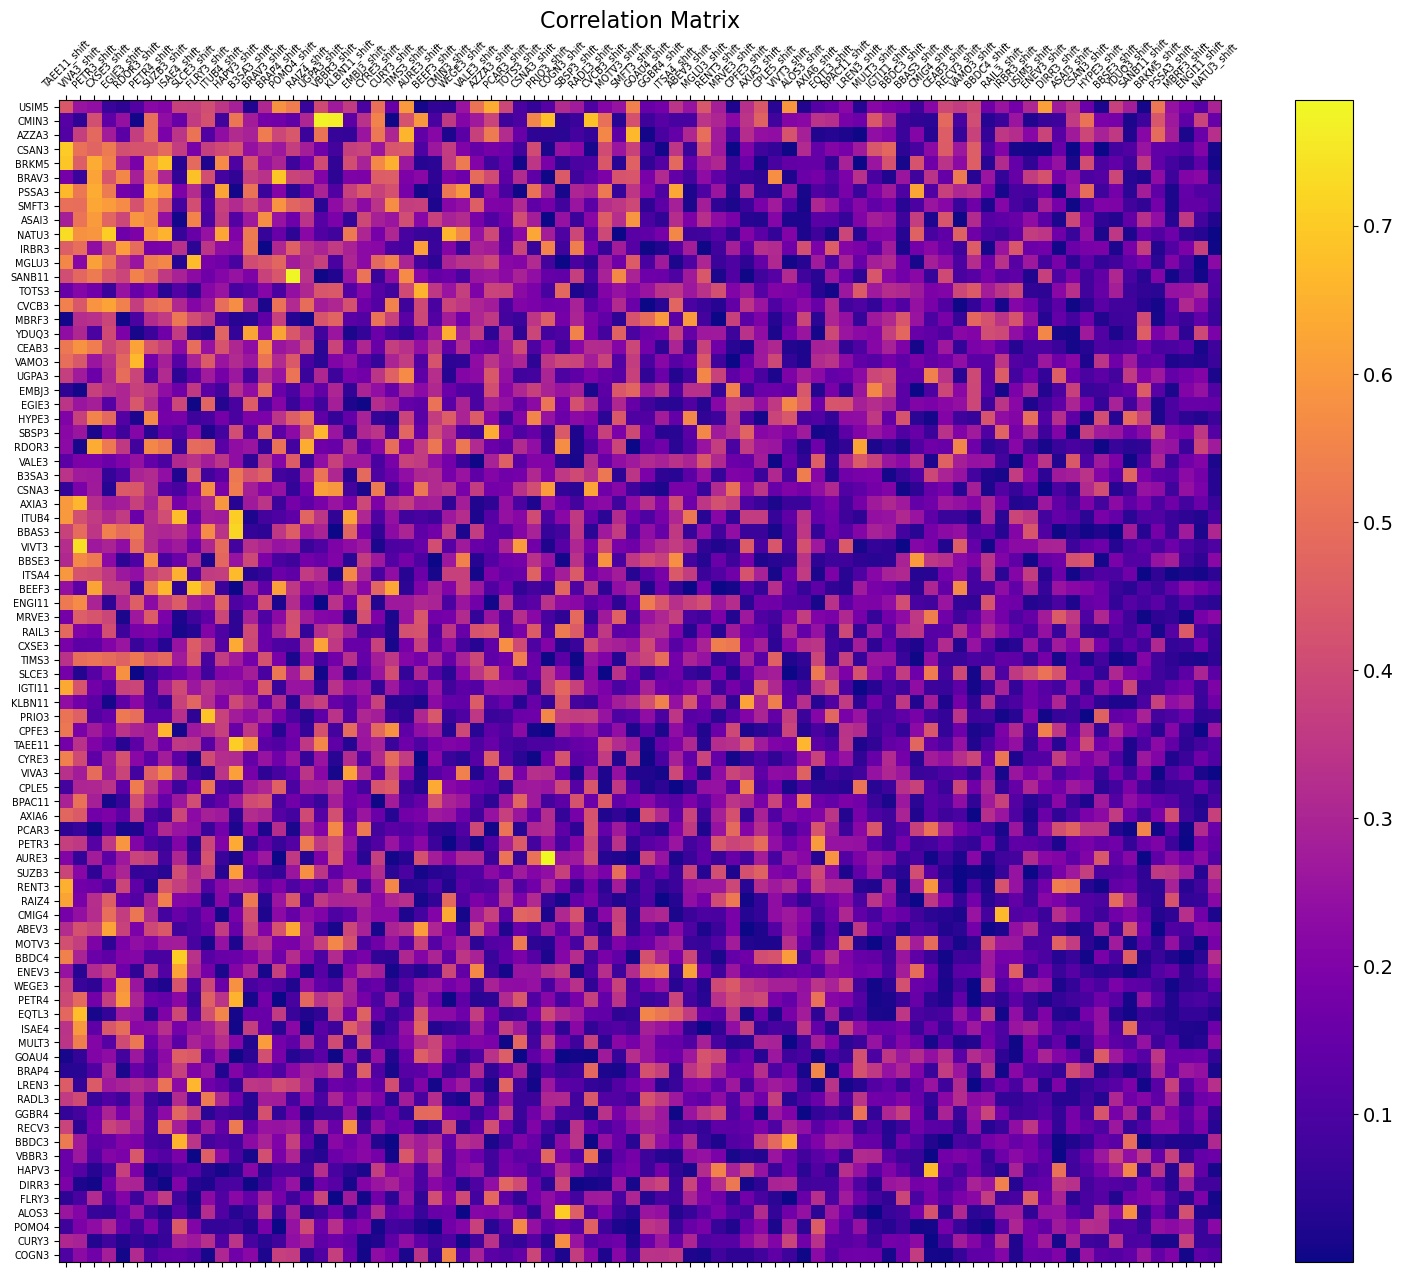

In [ ]:
df_stocks = stocks.Normalize()
df_stocks = df_stocks[prices]
df_stocks_shifted = df_stocks.shift(-1)

df_stocks.columns = [col.replace("_adjustedClose_log_return_1","") for col in df_stocks.columns]
df_stocks_shifted.columns = [col.replace("_adjustedClose_log_return_1","_shift") for col in df_stocks_shifted.columns]

corr_matrix =  pd.DataFrame(
    {col_j: df_stocks.corrwith(df_stocks_shifted[col_j], axis=0) for col_j in df_stocks_shifted.columns}
)

row_order = corr_matrix.abs().sum(axis=1).sort_values(ascending=False).index
col_order = corr_matrix.abs().sum(axis=0).sort_values(ascending=False).index

corr_matrix = corr_matrix.loc[row_order, col_order].abs()
print(df_stocks)
print(corr_matrix)
print(corr_matrix)
cmap = plt.colormaps["plasma"] # Colour map (there are many others)
f = plt.figure(figsize=(19, 15))
plt.matshow(corr_matrix, fignum=f.number, cmap=cmap)
plt.xticks(range(corr_matrix.select_dtypes(['number']).shape[1]), corr_matrix.select_dtypes(['number']).columns , fontsize=7
           , rotation=45)
plt.yticks(range(corr_matrix.select_dtypes(['number']).shape[1]), corr_matrix.select_dtypes(['number']).index , fontsize=7
           , rotation=0)
cb = plt.colorbar(cmap=cmap)
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

In [ ]:
corr_matrix.columns = [col.replace("_shift","") for col in corr_matrix.columns]
print(corr_matrix)

         TAEE11     VIVA3     PETR3     CXSE3     EGIE3     RDOR3     PETR4  \
USIM5  0.440005  0.254549  0.236991  0.062542  0.048959  0.112967  0.221202   
CMIN3  0.118529  0.048072  0.417086  0.136501  0.243840  0.007662  0.498846   
AZZA3  0.110596  0.373396  0.483879  0.279036  0.126316  0.369004  0.497839   
CSAN3  0.700899  0.503902  0.470220  0.527657  0.414256  0.427673  0.428331   
BRKM5  0.695817  0.455695  0.638656  0.541848  0.295781  0.187142  0.605512   
...         ...       ...       ...       ...       ...       ...       ...   
FLRY3  0.044274  0.092960  0.314399  0.109283  0.206382  0.073321  0.247751   
ALOS3  0.259381  0.211402  0.058424  0.057633  0.133500  0.248605  0.071885   
POMO4  0.074410  0.196196  0.231979  0.302354  0.154286  0.081966  0.202532   
CURY3  0.307571  0.288480  0.028636  0.079679  0.026180  0.058553  0.036879   
COGN3  0.106986  0.227571  0.170292  0.283662  0.007379  0.315697  0.100515   

          SUZB3     ISAE4     SLCE3  ...     CSAN3 

In [ ]:
#print(corr_matrix)
best_pairs = {}
best_options = []
for col in corr_matrix.columns:
   #print(f"Analyzing column: {col}")
   for row in corr_matrix.index:
       if col != row:
            #print(f"Checking pair: {row} and {col}")
            corr_value = corr_matrix.loc[row, col]
            if abs(corr_value) > 0.7:
                best_pairs[(row, col)] = corr_value
            if row not in best_options and abs(corr_value) > 0.7:
                best_options.append(row)
            if col not in best_options and abs(corr_value) > 0.7:
                best_options.append(col)
print(len(best_pairs))
print(best_pairs)
print(len(best_options))
print(best_options) 

13
{('CSAN3', 'TAEE11'): 0.7008993654271721, ('NATU3', 'TAEE11'): 0.7337513516840566, ('VIVT3', 'VIVA3'): 0.7396069267110942, ('NATU3', 'CXSE3'): 0.7062843579260899, ('BBDC4', 'ISAE4'): 0.7062484712579619, ('ITUB4', 'HAPV3'): 0.7076168142262554, ('BBAS3', 'HAPV3'): 0.7218202172332379, ('TAEE11', 'HAPV3'): 0.7071504086322175, ('SANB11', 'POMO4'): 0.7776701905155884, ('CMIN3', 'UGPA3'): 0.7745642211462487, ('CMIN3', 'VBBR3'): 0.7658753283372111, ('AURE3', 'PRIO3'): 0.7850823380483213, ('ALOS3', 'COGN3'): 0.7035345901276412}
20
['CSAN3', 'TAEE11', 'NATU3', 'VIVT3', 'VIVA3', 'CXSE3', 'BBDC4', 'ISAE4', 'ITUB4', 'HAPV3', 'BBAS3', 'SANB11', 'POMO4', 'CMIN3', 'UGPA3', 'VBBR3', 'AURE3', 'PRIO3', 'ALOS3', 'COGN3']


In [ ]:
prices = [stock+"_adjustedClose_log_return_1" for stock in best_options]
stocks = stock_dataframe(best_options)
stocks.get_brapi_stock_data(RANGE='3mo',INTERVALO='1d')

# convert Date to Day, Month and Year columns
stocks.Date_Convert()
print(stocks.stock)
for option in best_options:
    stocks.Get_Technical_Indicators(option+"_adjustedClose")
df_stocks = stocks.Normalize()
print(df_stocks)

Buscando dados diários para o ativo: CSAN3...
Buscando dados diários para o ativo: TAEE11...
Buscando dados diários para o ativo: NATU3...
Buscando dados diários para o ativo: VIVT3...
Buscando dados diários para o ativo: VIVA3...
Buscando dados diários para o ativo: CXSE3...
Buscando dados diários para o ativo: BBDC4...
Buscando dados diários para o ativo: ISAE4...
Buscando dados diários para o ativo: ITUB4...
Buscando dados diários para o ativo: HAPV3...
Buscando dados diários para o ativo: BBAS3...
Buscando dados diários para o ativo: SANB11...
Buscando dados diários para o ativo: POMO4...
Buscando dados diários para o ativo: CMIN3...
Buscando dados diários para o ativo: UGPA3...
Buscando dados diários para o ativo: VBBR3...
Buscando dados diários para o ativo: AURE3...
Buscando dados diários para o ativo: PRIO3...
Buscando dados diários para o ativo: ALOS3...
Buscando dados diários para o ativo: COGN3...
                  date  CSAN3_open  CSAN3_high  CSAN3_low  CSAN3_close  \
0  2

C:\Users\evang\AppData\Local\Temp\ipykernel_4792\1782059863.py:118: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  stock_normalized = (self.stock - self.stock.mean())/self.stock.std()


In [ ]:
Portfolio = PortfolioOptimization(df_stocks, best_options)
df_weights = Portfolio.get_optimal_weights(rfree=0.0001)
print(df_weights)

    CSAN3_weight  TAEE11_weight  NATU3_weight  VIVT3_weight  VIVA3_weight  \
0       0.026500   6.603647e-02      0.063234  0.000000e+00      0.061451   
1       0.026500   6.603647e-02      0.063234  0.000000e+00      0.061451   
2       0.056075   3.867739e-02      0.044378  4.866725e-03      0.059704   
3       0.041312   3.608813e-02      0.035393  2.244566e-02      0.042238   
4       0.116914   3.859137e-02      0.000000  2.824923e-02      0.051340   
..           ...            ...           ...           ...           ...   
57      0.013453   1.886321e-01      0.056983  7.681020e-02      0.105532   
58      0.000000   3.580407e-02      0.061482  5.493396e-02      0.051089   
59      0.080839   1.550943e-02      0.032922  2.053246e-14      0.028629   
60      0.000000   2.403282e-01      0.056318  1.314844e-14      0.018351   
61      0.034272   5.218312e-15      0.042700  8.992322e-02      0.030005   

    CXSE3_weight  BBDC4_weight  ISAE4_weight  ITUB4_weight  HAPV3_weight  \

In [ ]:
prep = data_prep(df_stocks, prices, prices, train_fraction=0.7, validation_fraction=0.15, rwin=7, offset=1)
sequences = prep.create_sequences() 
targetval = prep.create_targetval()
train_sequences, validation_sequences, test_sequences, train_targets, validation_targets, test_targets = prep.split_data()
print("Number of training sequences: ", len(train_sequences))
print("Number of validation sequences: ", len(validation_sequences))
print("Number of test sequences: ", len(test_sequences))
print("Number of training targets: ", len(train_targets))
print("Number of validation targets: ", len(validation_targets))    
print("Number of test targets: ", len(test_targets))


len(self.sequences) =  56
len(self.targetval) =  62
self.rwin =  7
self.train_fraction =  0.7
self.validation_fraction =  0.15
train_split =  38
valdation_split =  8
Number of training sequences:  38
Number of validation sequences:  8
Number of test sequences:  10
Number of training targets:  38
Number of validation targets:  8
Number of test targets:  8


In [ ]:
model = Sequential()
model.add(LSTM(len(features)*rwin, activation='tanh', input_shape=(rwin, len(features))))
model.add(Dense(len(features),activation='linear'))  # Output layer for regression
model.add(Dense(int(len(features)/2),activation='tanh'))  # Output layer for regression
model.add(Dense(len(targets),activation='tanh'))  # Output layer for regression
model.compile(optimizer='adam', loss='mse')

: 

In [ ]:
train_sequences = np.asarray(train_sequences).astype('float32')
validation_sequences = np.asarray(validation_sequences).astype('float32')
test_sequences = np.asarray(test_sequences).astype('float32')
train_targets = np.asarray(train_targets).astype('float32')
validation_targets = np.asarray(validation_targets).astype('float32')
test_targets = np.asarray(test_targets).astype('float32')